# Homework 10
Author: uc288

# TIME SERIES ANALYSIS

## Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

### DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
# from IPython.display import Image
# Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.dates as mdates

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

%pylab inline

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## Data Reading

In [3]:
mtaRides = np.load('MTA_Fare.npy')

In [4]:
mtaRides.shape

(600, 23, 194)

In [5]:
mtaRides = mtaRides.astype(float)

In [6]:
mtaRides[mtaRides == -1.] = np.NaN

In [7]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

May 21, 2010 - Friday
Feb 21, 2014 - Friday

In [8]:
dates = pd.date_range(start='05/21/2010', periods=194, freq='W-FRI')
dates

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

In [9]:
np.nansum(mtaRides,axis=0).shape

(23, 194)

Getting the sum by axis 0 returns the total number of swipes per card type per week.

In [10]:
np.nansum(mtaRides,axis=1).shape

(600, 194)

Getting the sum by axis 1 returns the total number of swipes per station type per week.

In [11]:
np.nansum(mtaRides,axis=2).shape

(600, 23)

Getting the sum by axis 2 returns the total number of swipes per station per card type for all the 194 weeks.

In [12]:
countPerCardType = np.nansum(mtaRides,axis=0)
countPerStation = np.nansum(mtaRides,axis=1)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [13]:
countPerStation.shape

(600, 194)

#### Getting the sum per week for determining the event.

In [14]:
allStations = np.nansum(countPerStation,axis=0)
allStations.shape

(194,)

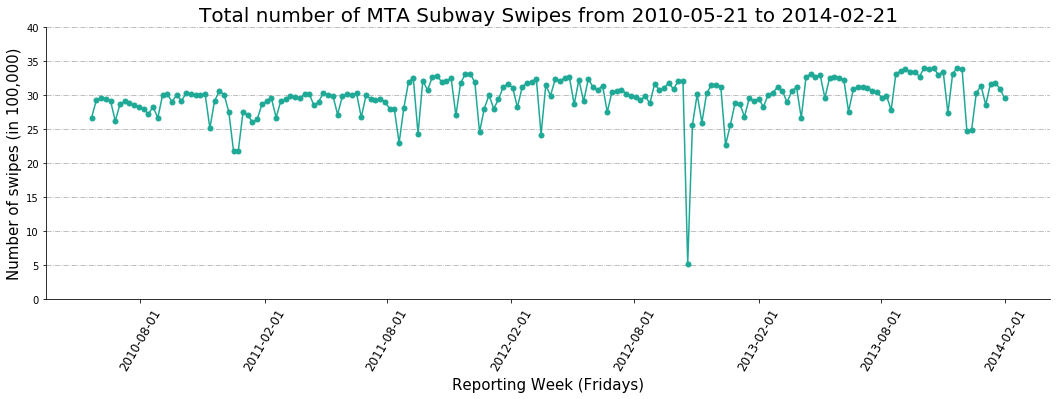

In [15]:
fig = pl.figure(figsize=(18,5))
ax = fig.add_subplot(111)

ax.plot(dates, allStations/1e6, '.-', ms=10, color='#1EA896')

ax.set_xlabel("Reporting Week (Fridays)", fontsize=15)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=15)

ax.set_xticklabels(dates, rotation=60, fontsize=12)

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_ylim([0,40])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total number of MTA Subway Swipes from 2010-05-21 to 2014-02-21", fontsize=20)

ax.grid(axis='y', linestyle='-.');

## Figure 1. Total number of MTA Subway Swipes from 2010-05-21 to 2014-02-21
This plot shows the total number of MTA subway swipes on a weekly basis from May 21, 2010 to February 21, 2014 (194 weeks). We can see that there is one particular outlier with a huge drop to around 500,000 swipes only that week from the regular trend of 2,500,000 to 3,500,000.

In [16]:
popMean = np.nanmean(allStations)
popStd = np.nanstd(allStations)

print("Mean: {:.4f}".format(popMean))
print("Standard Deviation: {:.4f}".format(popStd))

Mean: 29781349.8711
Standard Deviation: 2983960.4217


In [17]:
thresholds = [popMean + 3 * popStd, 
              popMean - 3 * popStd]
print("Thresholds (3std): {}".format(thresholds))

Thresholds (3std): [38733231.136236683, 20829468.606031362]


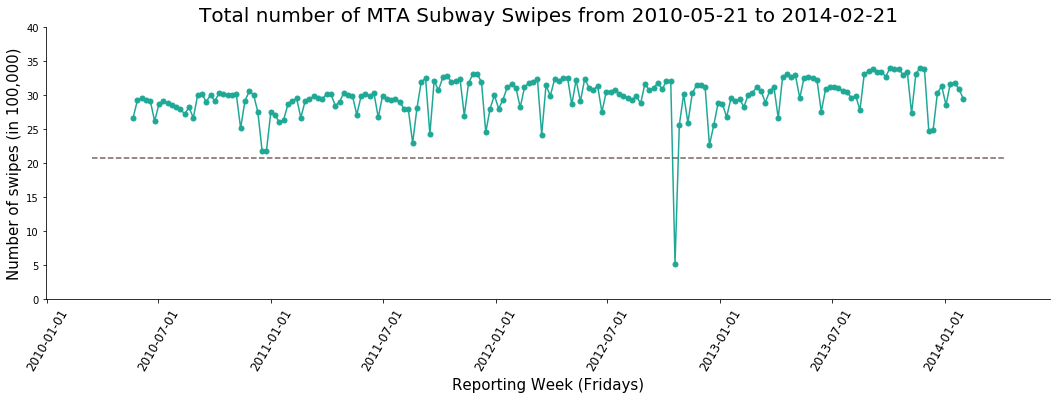

In [18]:
fig = pl.figure(figsize=(18,5))
ax = fig.add_subplot(111)

ax.plot(dates, allStations/1e6, '.-', ms=10, color='#1EA896')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1]/1e6, thresholds[1]/1e6], color='#523F38', linestyle='--', alpha=0.8);

ax.set_xlabel("Reporting Week (Fridays)", fontsize=15)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=15)

ax.set_xticklabels(dates, rotation=60, fontsize=12)

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_ylim([0,40])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total number of MTA Subway Swipes from 2010-05-21 to 2014-02-21", fontsize=20);

## Figure 2. Total number of MTA Subway Swipes from 2010-05-21 to 2014-02-21 with threshold at $3 - \sigma$
 
Similar to Figure 1 with a line at 20,829,469 swipes, which signifies the lower bound of the 99th percentile of the distribution. The point below the line is the "event" which around the week of October 19, 2012 to October 26, 2012. 

Reference: http://www.cnn.com/2013/07/13/world/americas/hurricane-sandy-fast-facts/index.html

In the CNN article, the week mentioned is October 22-29, 2012 which is more or less around the date of the data as well.

In [19]:
event = np.where(allStations < thresholds[1])
event

(array([126]),)

In [20]:
dates[126]

Timestamp('2012-10-19 00:00:00', freq='W-FRI')

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

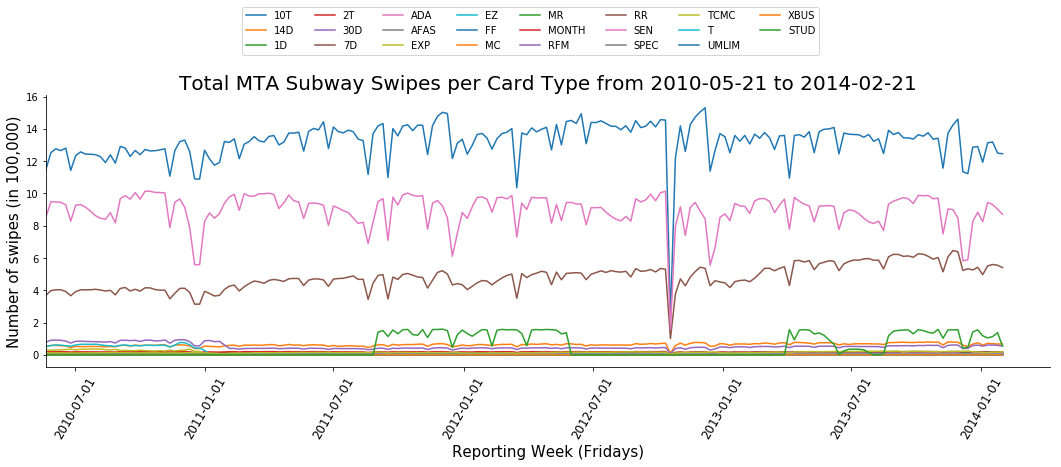

In [21]:
fig = pl.figure(figsize=(18,5))
ax = fig.add_subplot(111)

for y_arr, label in zip(countPerCardType/1e6, ridetype):
    ax.plot(dates, y_arr, label=label.upper())

ax.set_xticklabels(dates, rotation=60, fontsize=12)
ax.set_xlim(dates[0])

ax.set_xlabel("Reporting Week (Fridays)", fontsize=15)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=15)

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

pl.legend(bbox_to_anchor=(0, 1.15, 0.77, .102), loc=4,
           ncol=8, borderaxespad=0., fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total MTA Subway Swipes per Card Type from 2010-05-21 to 2014-02-21", fontsize=20);

## Figure 3. Total number of MTA Subway Swipes per Card Type from 2010-05-21 to 2014-02-21

This is a plot of the total number of MTA subways swipes per card type from May 21, 2010 to February 21, 2014 (194 weeks). We can't really see much except for those 3 card types which seem to have more use as compared to the other 20 card types. In this plot, we can also see the drop that we noticed from Figure 1 which happened because of Hurricane Sandy.

Converting the counts per card type to a pandas DataFrame for easier handling wuth the pandas rolling function.

In [22]:
dfCardType = pd.DataFrame(countPerCardType.T)
dfCardType.set_index(dates, inplace=True)
dfCardType.columns = ridetype

In [23]:
dfCardType.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-21,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
2010-05-28,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2010-06-04,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
2010-06-11,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
2010-06-18,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


In [24]:
cardType_rmean = dfCardType.rolling(center=False, axis=0, window=10).mean()
cardType_rstd = dfCardType.rolling(center=False, axis=0, window=10).std()

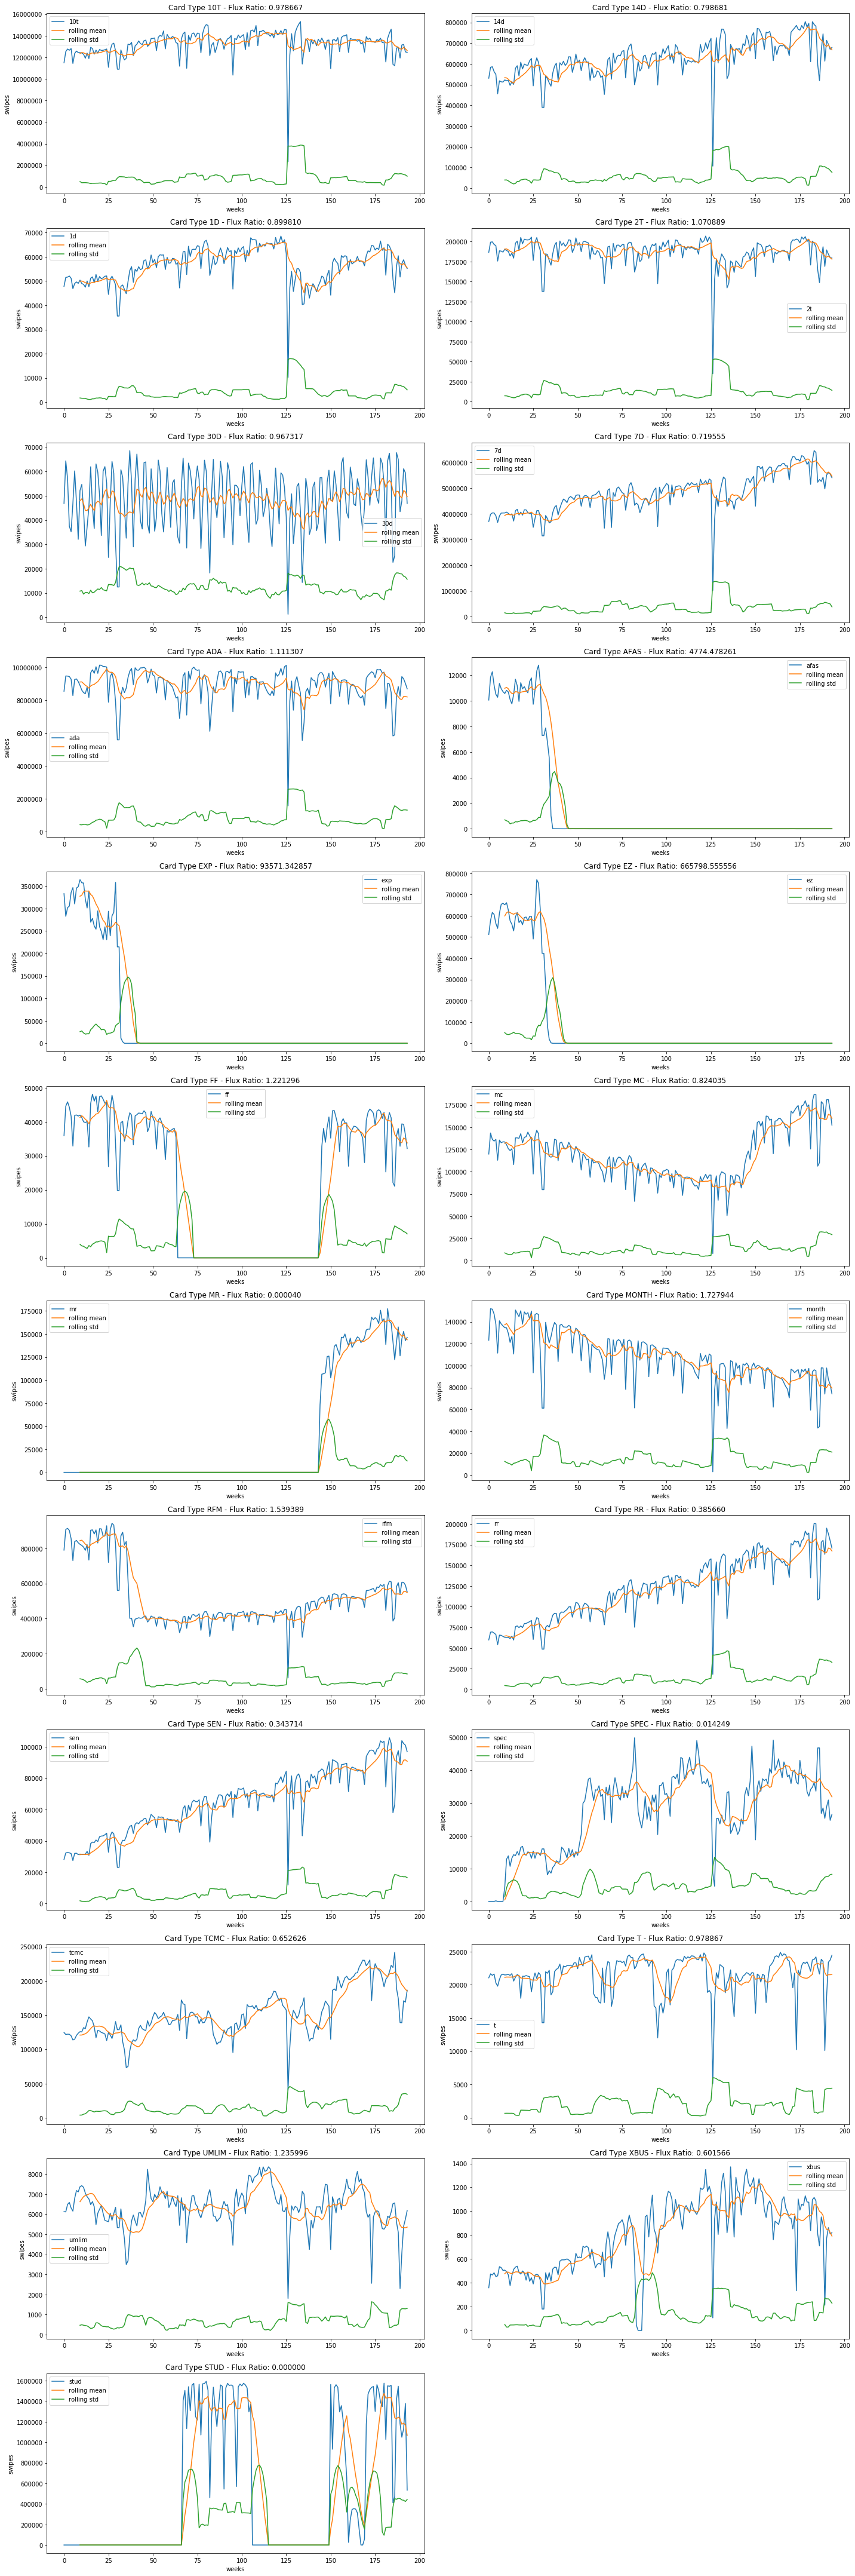

In [25]:
columns = dfCardType.columns
fig = pl.figure(figsize=(20,60))
ratio = dict()

for i in range(len(columns)):
    ts = dfCardType.iloc[:,i]
    ts_rmean = cardType_rmean.iloc[:,i]
    ts_rstd = cardType_rstd.iloc[:,i]
    
    ts_ratio = ts.iloc[0:10].mean() / ts.iloc[-10:].mean()
    ratio[ts.name.upper()] = ts_ratio
    
    ax = fig.add_subplot(12,2,i+1)
    ax.plot(np.arange(len(ts)), ts, label=columns[i])
    ax.plot(np.arange(len(ts)), ts_rmean, label="rolling mean")
    ax.plot(np.arange(len(ts)), ts_rstd, label="rolling std")
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_xlabel('weeks')
    ax.set_ylabel('swipes')
    ax.set_title('Card Type {} - Flux Ratio: {:.6f}'.format(ts.name.upper(), ts_ratio))
    pl.legend(fontsize=10)

pl.tight_layout()

## Figure 4. MTA Subway Swipes per Card Type with Rolling Mean and Rolling Standard Deviation (individual plots)

In this figure with 23 subplots, we can see the trend of each card type individually and see which card types are stationary, which have increased in popularity and which have decreased in popularity.

AFAS, EXP and EZ card types show a drastic drop after the 25th week. MR on the other hand only started to be used around 140th week. Student and full fare card types show missing data in between or it is possible that it was discontinued and brought back.

The 30-Day card type looks to be a stationary time series. Other card types show different trends.

## Augmented Dickey-Fuller unit root test.

If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Null hypothsis: there is a "unit root": i.e. the series is not stationary

In [26]:
def test_stationarity(timeseries):
    adftest = sm.tsa.adfuller(timeseries)
    
    if (adftest[0] > adftest[4]['5%']):
        print("{} \t | The series is not stationary".format(timeseries.name))
    else:
        print("{} \t | The series is stationary".format(timeseries.name))

In [27]:
for i in range(len(columns)):
    test_stationarity(dfCardType.iloc[:,i])

10t 	 | The series is stationary
14d 	 | The series is not stationary
1d 	 | The series is not stationary
2t 	 | The series is stationary
30d 	 | The series is stationary
7d 	 | The series is not stationary
ada 	 | The series is stationary
afas 	 | The series is not stationary
exp 	 | The series is stationary
ez 	 | The series is not stationary
ff 	 | The series is not stationary
mc 	 | The series is not stationary
mr 	 | The series is not stationary
month 	 | The series is not stationary
rfm 	 | The series is not stationary
rr 	 | The series is not stationary
sen 	 | The series is not stationary
spec 	 | The series is not stationary
tcmc 	 | The series is stationary
t 	 | The series is stationary
umlim 	 | The series is stationary
xbus 	 | The series is not stationary
stud 	 | The series is not stationary


In [28]:
for k, v in sorted(ratio.items(), key=lambda kv: (-kv[1], kv[0])):
    print("{} \t | {:.6f}".format(k, v))

EZ 	 | 665798.555556
EXP 	 | 93571.342857
AFAS 	 | 4774.478261
MONTH 	 | 1.727944
RFM 	 | 1.539389
UMLIM 	 | 1.235996
FF 	 | 1.221296
ADA 	 | 1.111307
2T 	 | 1.070889
T 	 | 0.978867
10T 	 | 0.978667
30D 	 | 0.967317
1D 	 | 0.899810
MC 	 | 0.824035
14D 	 | 0.798681
7D 	 | 0.719555
TCMC 	 | 0.652626
XBUS 	 | 0.601566
RR 	 | 0.385660
SEN 	 | 0.343714
SPEC 	 | 0.014249
MR 	 | 0.000040
STUD 	 | 0.000000


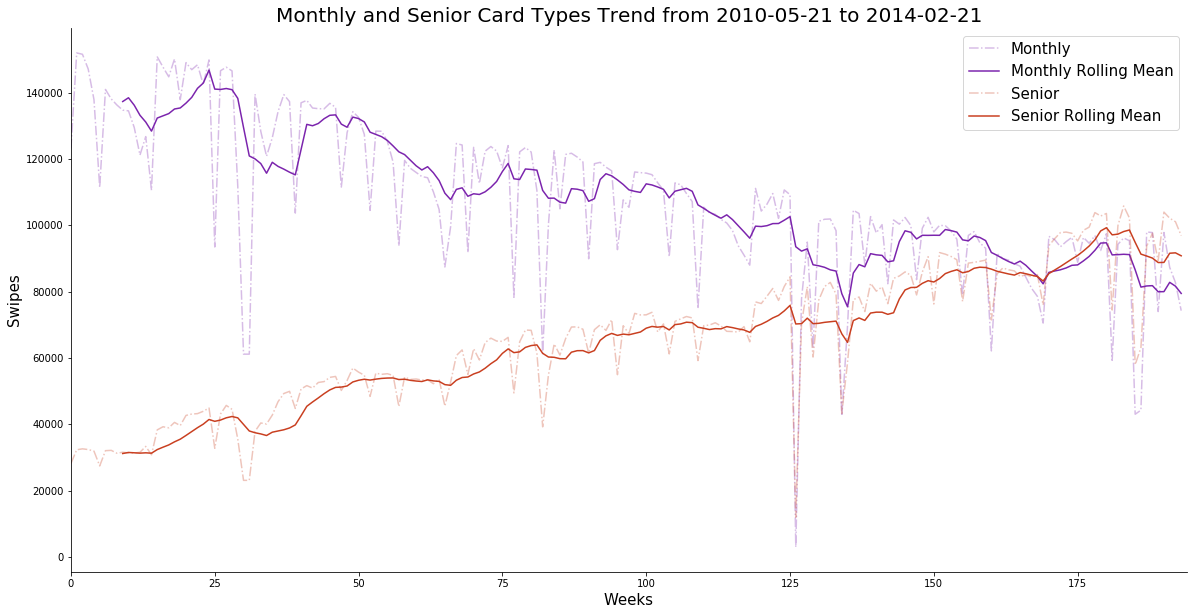

In [29]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(np.arange(len(dfCardType['month'])), dfCardType['month'], label="Monthly", c='#7B24AD', linestyle='-.',alpha=0.3)
ax.plot(np.arange(len(dfCardType['month'])), cardType_rmean['month'], label="Monthly Rolling Mean", c='#7B24AD')
ax.plot(np.arange(len(dfCardType['sen'])), dfCardType['sen'], label="Senior", c='#C93F20',linestyle='-.', alpha=0.3)
ax.plot(np.arange(len(dfCardType['sen'])), cardType_rmean['sen'], label="Senior Rolling Mean", c='#C93F20')
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.set_xlabel('Weeks', fontsize=15)
ax.set_ylabel('Swipes', fontsize=15)
ax.set_xlim(0,194)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Monthly and Senior Card Types Trend from 2010-05-21 to 2014-02-21", fontsize=20);
pl.legend(fontsize=15);

## Figure 5. Rolling Mean of MTA Subway Swipes of Monthly and Senior Citizen/Disabled card types with the actual time series.

The purple solid line is the rolling mean for the total MTA subway swipes for the Monthly card type which shows a steady decrease in popularity over the weeks. The light purple dash-dotted line signifies the actual time series for the Monthly card type for the span of 194 weeks. The flux ratio for this card type is at 1.72 which means it was 1.72 times more popular in the first 10 weeks of the reporting period than it was in the last 10 weeks of the reporting period.

The red solid line is the rolling mean for the total MTA subway swipes for the Senior Citizen/Disabled card type which shows a steady increase in popularity over the weeks. The light red dash-dotted line signifies the actual time series for the Senior Citizen/Disabled card type for the span of 194 weeks. As for the flux ratio, this card type is at 0.34 which means it was less popular in the beginning than at the end.


*Note: There were other card types which had higher and lower flux ratios but I did not choose them because of zero values at some/most part of the time series.*

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

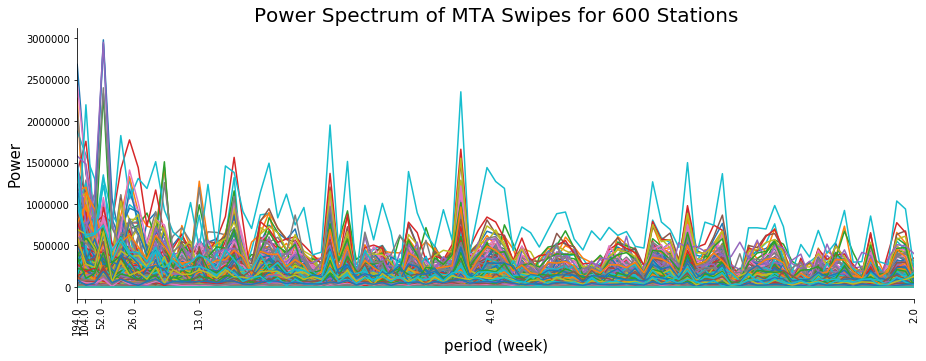

In [30]:
N = len(dates)
allperiods = [1/194.0, 1/104.0, 1/52.0, 1/26.0, 1/13.0, 1/4.0, 1/2.0]

fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(countPerStation)):
    f = np.abs(np.fft.rfft(countPerStation[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')

ax.set_xlim([1/194.0, 1/2.0])
ax.set_xticks(allperiods)
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], fontsize=10, rotation=90)
ax.set_xlabel("period (week)", fontsize=15)
ax.set_ylabel("Power", fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Power Spectrum of MTA Swipes for 600 Stations", fontsize=20);

## Figure 6: Power of MTA Swipes for 600 Stations
This is the power spectrum for the MTA swipes for all 600 stations in the dataset. Since there are 600 lines here, it can be hard to the periodicity of the individual stations. However, we can see certain spikes in a a lot of the stations at around the 52 week and over 4 weeks (roughly 5-6 weeks).

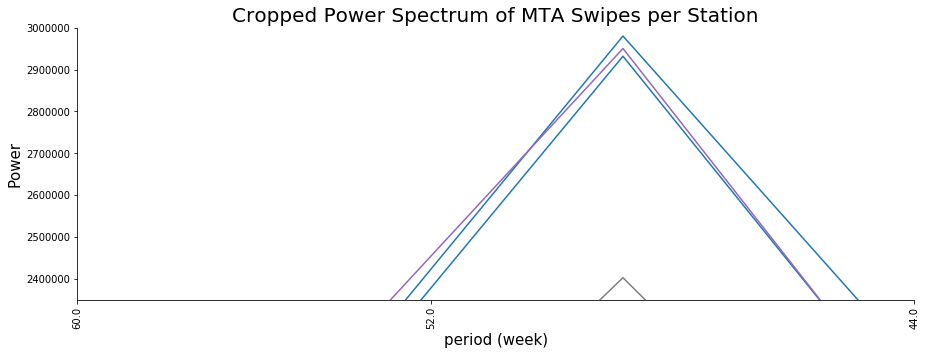

In [31]:
N = len(dates)
allperiods = [1/194.0, 1/104.0, 1/52.0, 1/26.0, 1/13.0, 1/4.0, 1/2.0]
station_index = []

fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(countPerStation)):
    f = np.abs(np.fft.rfft(countPerStation[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    if (f[4] > 2350000):
        station_index.append(i)

ax.set_xlim([1/60.0, 1/44.0])
ax.set_xticks([1/60.0, 1/52.0, 1/44.0])
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10, rotation=90)

ax.set_ylim([2350000, 3000000])
ax.set_xlabel("period (week)", fontsize=15)
ax.set_ylabel("Power", fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Cropped Power Spectrum of MTA Swipes per Station", fontsize=20);

## Figure 7. Zoomed in Power Spectrum of MTA Swipes per Station
This is actually the same plot as Figure 6 but only showing the highest peak we see at around the 52 week period. This was also visually cropped on the power y-axis to show only 4 out of the 600 stations.

In [32]:
station_index

[0, 150, 194, 327]

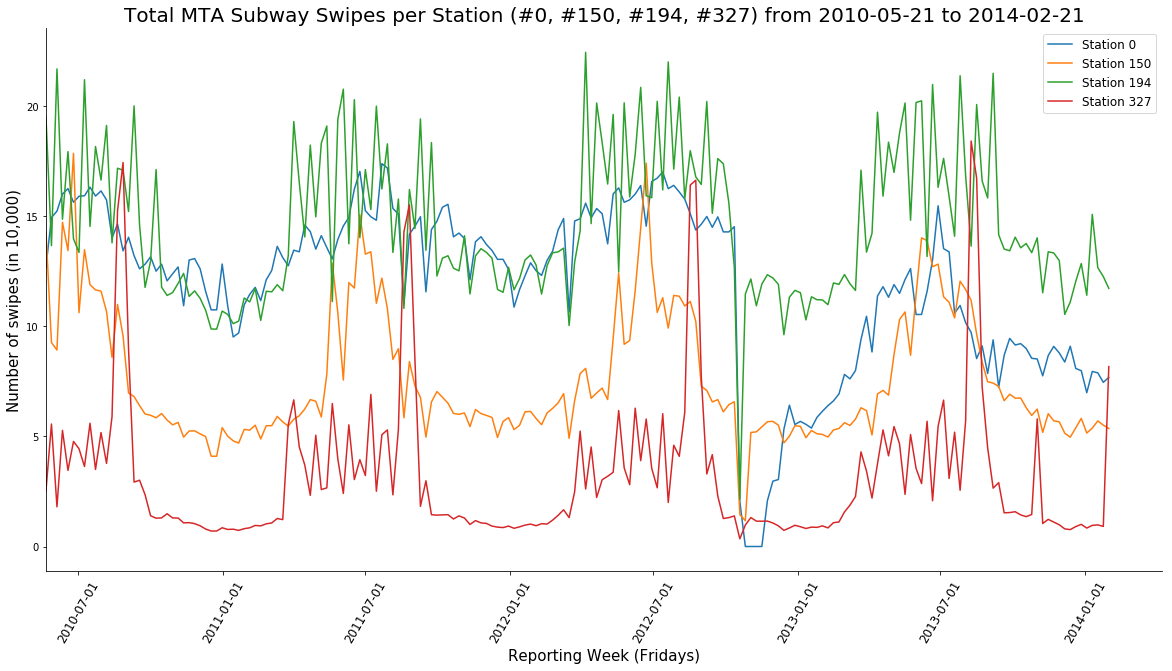

In [33]:
fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for i in range(len(station_index)):
    ax.plot(dates, countPerStation[station_index[i]]/1e4, label="Station {}".format(station_index[i]))

ax.set_xlabel("Reporting Week (Fridays)", fontsize=15)
ax.set_ylabel("Number of swipes (in 10,000)", fontsize=15)


ax.set_xticklabels(dates, rotation=60, fontsize=12)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim(dates[0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total MTA Subway Swipes per Station (#0, #150, #194, #327) from 2010-05-21 to 2014-02-21", fontsize=20);
ax.legend(fontsize=12);

## Figure 8. Total MTA Subway Swipes for Stations #0, #150, #194, and #327 from 2010-05-21 to 2014-02-21

This shows the four identified stations with a high periodcity at 52 weeks (1 year) period. Over the span of 52 weeks, we can see that there is a spike and then a huge drop in usage but that goes back up again more or less at the same time frame.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

In [34]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T

In [35]:
tots.shape

(13800, 194)

In [36]:
tots = tots[tots.std(1)>0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [37]:
tots.shape

(7660, 194)

In [38]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [39]:
vals.shape

(7660, 194)

In [40]:
range_n_clusters = np.arange(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(vals)
    silhouette_avg = silhouette_score(vals, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.28792444716846705
For n_clusters =3, the average silhouette_score is :0.2644698313721373
For n_clusters =4, the average silhouette_score is :0.24871854286436965
For n_clusters =5, the average silhouette_score is :0.205894647287875
For n_clusters =6, the average silhouette_score is :0.21544699548514007
For n_clusters =7, the average silhouette_score is :0.21404880477792546
For n_clusters =8, the average silhouette_score is :0.21323011100248895
For n_clusters =9, the average silhouette_score is :0.21416374043546016


In [41]:
n = 2
km = KMeans(n_clusters=n, random_state=324)
cluster_labels = km.fit(vals)
pca = PCA(n)
Xproj = pca.fit_transform(vals)

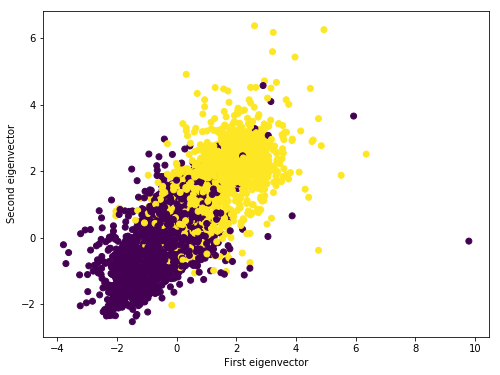

In [42]:
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(vals[:, 0], vals[:, 1], c=cluster_labels.labels_, cmap=plt.cm.viridis)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.show()